# Средний вектор по неделям по новостным сайтам: LENTA, RBC, KP, VESTI

In [32]:
import json
import numpy as np
import re
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import datetime
from matplotlib.dates import MO

%matplotlib inline

In [2]:
class News:
    def __init__(self, id, date, title, content, url, siteType):
        self.id = id
        self.date = date
        self.title = title
        self.content = content
        self.url = url
        self.siteType = siteType
    
    @classmethod
    def from_json(cls, json_str):
        json_dict = json.loads(json_str)
        return cls(**json_dict)

In [29]:
def plot_cos_mean(cos_days, start_day, end_day, label):
    plt.rcParams['figure.figsize'] = (20.0, 8.0)
    plt.rcParams['font.size'] = 12
    fig, ax = plt.subplots()

    myFmt = mdates.DateFormatter('%d.%m.%Y')
    ax.xaxis.set_major_formatter(myFmt)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO))

    datemin = datetime.datetime.fromtimestamp(start_day/1000) - datetime.timedelta(days=7)
    datemax = datetime.datetime.fromtimestamp(end_day/1000) + datetime.timedelta(days=7)
    ax.set_xlim(datemin, datemax)

    x = list(map(lambda d: datetime.datetime.fromtimestamp(int(d)/1000), cos_days.keys()))
    y = list(cos_days.values())

    plt.plot(x, y, label = label)
    plt.legend(loc='upper right')
    plt.gcf().autofmt_xdate(rotation=60)

In [4]:
def load_sorted_news(path):
    news = []
    with open(path, encoding="utf8") as f:
        for line in f:
            news.append(News.from_json(line))
    return sorted(news, key=lambda w: w.date)

In [5]:
def coumpute_tfidf_matrix(news):
    tfidf_vectorizer = TfidfVectorizer(use_idf=True, tokenizer=lambda text: text.split(" "), ngram_range=(1, 3))
    tfidf_matrix = tfidf_vectorizer.fit_transform(map(lambda n: n.content, news))
    return (tfidf_vectorizer, tfidf_matrix)

In [6]:
def compute_cos(start_day, end_day, step, news, year_mean_vector, vectorizer):
    cos_days = {}

    for start in range(start_day, end_day, step):
        end = start + step
        day_news = list(filter(lambda w: w.date >= start and w.date <= end, news))
        tfidf_day = vectorizer.transform(map(lambda n: n.content, day_news))
        day_mean = np.array(tfidf_day.mean(axis=0))[0]
        cos_days[str(start)] = spatial.distance.cosine(year_mean_vector, day_mean)
        
    return cos_days

In [7]:
def cos_mean_days(path, start_year_day, end_year_day, step):
    news = load_sorted_news(path)
    
    print("count news: %s" % len(news))
    print("start time: %s millis" % list(map(lambda w: w.date, news[:1]))[0])
    print("end time: %s millis" % list(map(lambda w: w.date, news[-1:]))[0])
    
    (vectorizer, tfidf_matrix) = coumpute_tfidf_matrix(news)
    year_mean = np.array(tfidf_matrix.mean(axis=0))[0]
    cos_days = compute_cos(start_year_day, end_year_day, step, news, year_mean, vectorizer)
    
    return cos_days

In [8]:
week_millis = 24*60*60*7*1000

## 2015 год

In [9]:
start_2015 = 1420059600*1000
end_2015 = 1451595599*1000
news_2015 = '/data/results/lenta.rbc.kp.vesti.2015.normalized.json'

cos_days_2015 = cos_mean_days(news_2015, start_2015, end_2015, week_millis)

count news: 38068
start time: 1420088098000 millis
end time: 1451594608000 millis


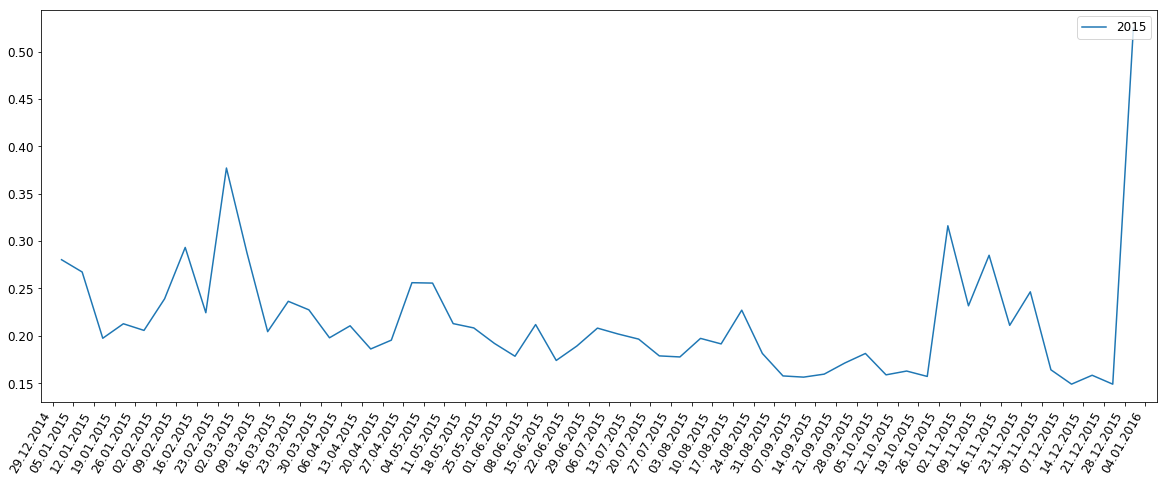

In [30]:
plot_cos_mean(cos_days_2015, start_2015, end_2015, "2015")

# 2016 год

In [11]:
start_2016 = 1451595600*1000
end_2016 = 1483217999*1000
news_2016 = '/data/results/lenta.rbc.kp.vesti.2016.normalized.json'

cos_days_2016 = cos_mean_days(news_2016, start_2016, end_2016, week_millis)

count news: 54166
start time: 1451599745000 millis
end time: 1483216945000 millis


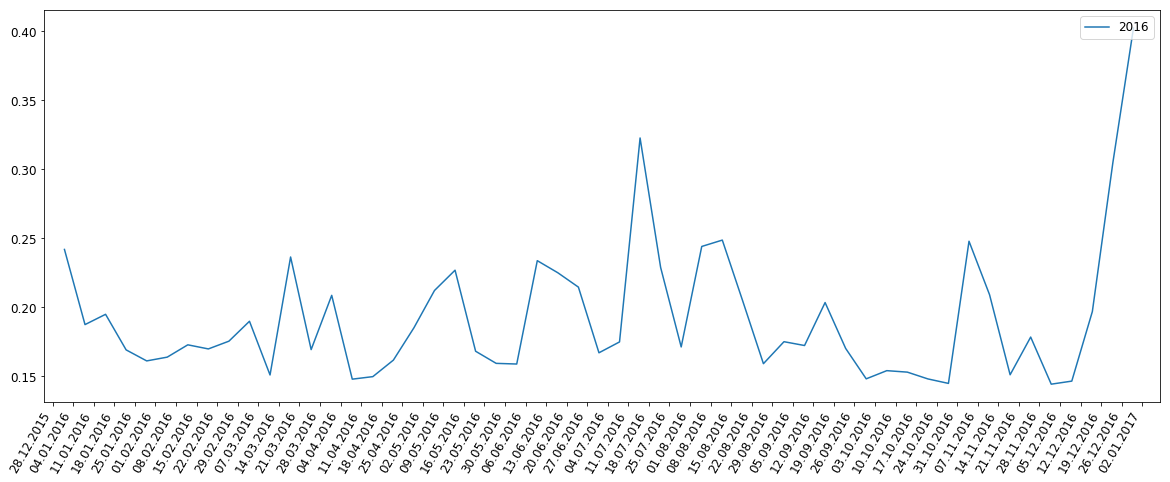

In [31]:
plot_cos_mean(cos_days_2016, start_2016, end_2016, "2016")

## 2015 и 2016 на одном графике сдвинутые по неделям

In [13]:
first_week_day_2015 = 1420405200*1000
first_week_day_2016 = 1493666160*1000

days_2015 = map(lambda d: int(d), cos_days_2015.keys())
days_2015 = sorted(list(filter(lambda d: d > first_week_day_2015, days_2015)))

days_2015 = list(cos_days_2015.keys())

days_2016 = map(lambda d: int(d), cos_days_2016.keys())
days_2016 = sorted(list(filter(lambda d: d > first_week_day_2016, days_2016)))

days_2016 = list(cos_days_2016.keys())

countdays = max([len(days_2015), len(days_2016)])

days_2015_by_nymber = {}
days_2016_by_nymber = {}

for day in range(0, countdays):
    if len(days_2015) > day:
        days_2015_by_nymber[day+1] = cos_days_2015[str(days_2015[day])]
    if len(days_2016) > day:
        days_2016_by_nymber[day+1] = cos_days_2016[str(days_2016[day])]

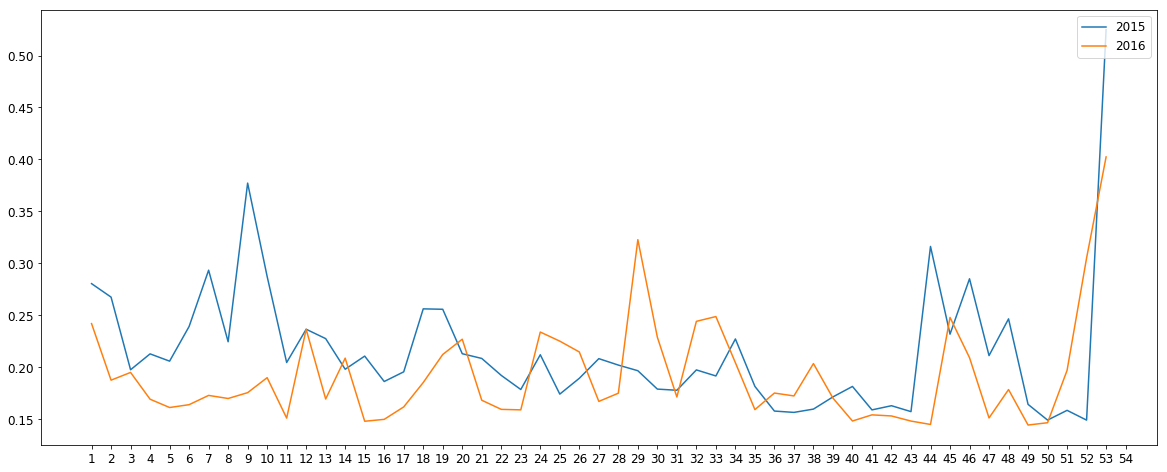

In [18]:
plt.rcParams['figure.figsize'] = (20.0, 8.0)
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots()

plt.xticks(range(1, countdays+2, 1))

plt.plot(list(days_2015_by_nymber.keys()), list(days_2015_by_nymber.values()), label = "2015")
plt.plot(list(days_2016_by_nymber.keys()), list(days_2016_by_nymber.values()), label = "2016")
plt.legend(loc='upper right')